<font size=6><b>Проект для "Викишоп" с BERT</b></font>

In [2]:
# !pip install cudf-cu11 --extra-index-url=https://pypi.nvidia.com
# !pip install cuml-cu11 --extra-index-url=https://pypi.nvidia.com

# Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

В столбце `text` содержится текст комментария, `toxic` - целевой признак.

In [ ]:
# !pip install spacy
# !python -m spacy download en_core_web_trf
# !pip install wordcloud
# !pip install pandas jupyter pandarallel requests tqdm
!pip install swifter
!pip install transformers
!pip install detoxify
# !pip install -U tqdm

# Подготовка данных

In [4]:
import os
import re
from collections import Counter

import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import f1_score, precision_recall_curve
from sklearn.dummy import DummyClassifier

import torch
import transformers
from transformers import BertTokenizer, BertModel
from detoxify import Detoxify

from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from tqdm import tqdm
import swifter
import warnings

from google.colab import drive

In [5]:
# блокнот запускался в colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# сделаем возможным параллельную обработку строковых колонок в pd.DataFrame
swifter.set_defaults(
    allow_dask_on_strings=True,
)

# добавляем новые методы pandas, которые используют progress bar
tqdm.pandas()

# задаем стили картинок по умолчанию
sns.set(style='darkgrid')

# будем игнорировать всплывающие предупреждения
warnings.filterwarnings('ignore')

In [7]:
# загружаем необходимые пакеты nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [8]:
# путь до файла
csv_file_path = './drive/MyDrive/Colab Notebooks/Yandex practicum/toxic_comments.csv'

# на сервере jupyter
if not os.path.exists:
    csv_file_path = '/datasets/toxic_comments.csv'

In [9]:
# загружаем данные
comments_df = pd.read_csv(csv_file_path, index_col=[0])

In [10]:
# выведем несколько комментариев: 3 токсичных и 3 не токсичных
for i, toxic in [(0, 'Untoxic'), (1, 'Toxic')]:
    print(f'{toxic} comments:', '\n', '=' * 70, sep='')
    print(*comments_df.query('toxic == @i').sample(3, random_state=154).text.values,
          sep=f'\n{"-" * 70}\n', end='\n'*3)

Untoxic comments:
"

Bisgh, I am kind of mentally different and like to do things that people dont approve of necessarliy but how would you like it if you were locked in your parents big house all alone most of the time either with just a computer and a TV??  I DO have friends but they have to come over and see me most of the time and I can't go see THEM without supervision.  If have some money from my parents but can't really live alone yet and I don't know when.  So a lot of my time is just sitting here ( Now Lucky wants to banish me for doing drugs.  Well what would you do if it was after midnight and you hadn't gone out in 2 days either?  I""m sorry, do what you have to do but please try to undrestand me. "
----------------------------------------------------------------------
LeaveSleaves you have been reported to the FBI Cyber Crimes division.  Please continue editing and make a further case agianst yourself.
----------------------------------------------------------------------


Как мы видим, тексты комментариев могут содержать много разнообразных символов и множество ошибок в словах. Также встречаются ссылки на сайты. Обрабатывать это добро будет сложновато.

In [11]:
print('Число пропусков:\n', comments_df.isna().sum(), sep='')
print('\nЧисло дубликатов:', comments_df.duplicated().sum())

Число пропусков:
text     0
toxic    0
dtype: int64

Число дубликатов: 0


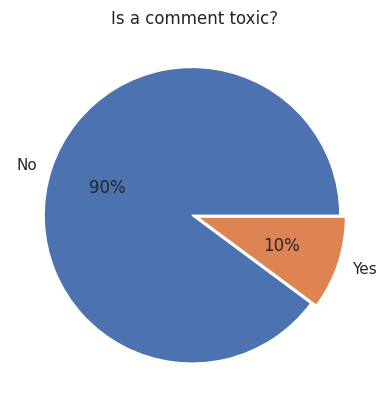

In [12]:
# посмотрим соотношение токсичных и нетоксичных комментариев
values = comments_df.toxic.value_counts()
values = values.rename(index={0: 'No', 1: 'Yes'})

plt.pie(values, labels=values.index, autopct='%.0f%%', explode=[0.02]*values.size)
plt.title('Is a comment toxic?');

Наблюдается явный дисбаланс классов. В связи с этим метрика `accuracy` неприменима, `f1` будет более информативной. Необходимо будет учитывать дисбаланс классов при разбиении данных на обучающую и тестовую выборки.

In [13]:
# проанализируем число символов, которое используется в комментариях, и число слов
comments_df['symbols'] = comments_df.text.apply(len)
comments_df['words'] = comments_df.text.apply(lambda x: len(x.split()))
comments_df[['symbols', 'words']].describe()

,symbols,words
count,159292.000000,159292.000000
mean,393.691303,67.213545
std,590.111825,99.133908
min,5.000000,1.000000
25%,95.000000,17.000000
50%,205.000000,36.000000
75%,435.000000,75.000000
max,5000.000000,1411.000000


Мы видим, что максимальное и среднее число символов и слов сильно отличается, std для них больше среднего, что говорит о наличии больших выбросов.

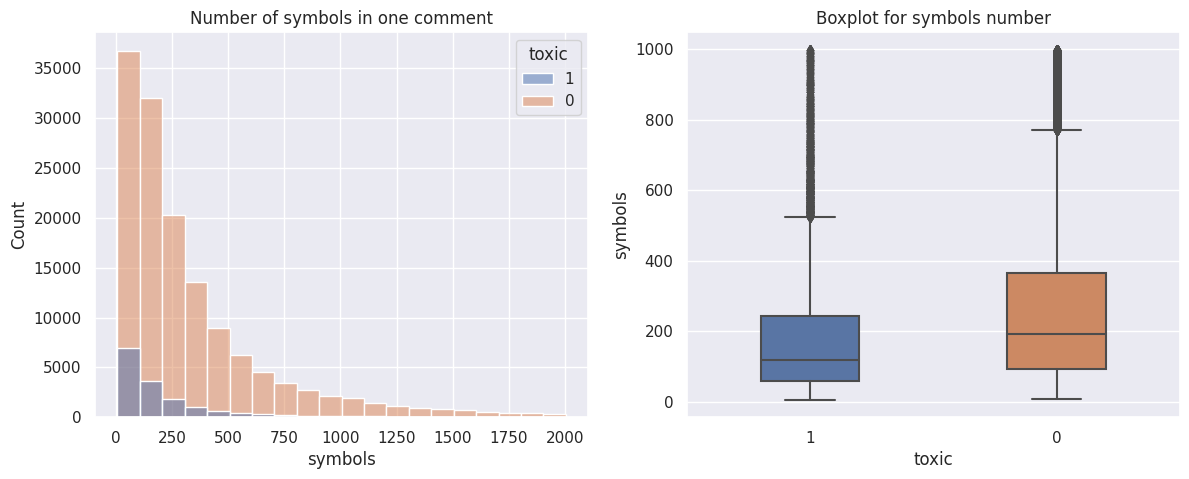

In [14]:
# построим гистограммы и боксплоты для числа символов в зависимоти от токсичности комментария
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(comments_df.query('symbols < 2000'), x='symbols', hue='toxic', binwidth=100, hue_order=[1, 0])
plt.title('Number of symbols in one comment')

plt.subplot(1, 2, 2)
sns.boxplot(comments_df.query('symbols < 1000'), y='symbols', x='toxic', width=0.4, order=[1, 0])
plt.title('Boxplot for symbols number');

Из представленных графиков видно, что статистика для токсичных и нетоксичных коментариев немного отличается: в токсичных комментариях чаще используют меньшее число символов.

In [15]:
# создадим трансформер, который будет чистить тексты и проводить лемматизацию слов

class TextProcesser(BaseEstimator, TransformerMixin):
    # словарь для замены слов с апострофами
    short = {
        "'ve": "have",
        "'re": "are",
        "'ll": "will",
        "'m": "am",
        "n't": "not",
        "'d": "'d",
    }

    # шаблон для URL
    url_pattern = r"(?:https?:\/\/)?(?:www\.)?([-a-zA-Z0-9@:%._\+~#=]{1,256})\."\
                           r"[a-zA-Z0-9()]{1,6}\b(?:[-a-zA-Z0-9()@:%_\+.~#?&\/=]*)"

    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.lemmas = {}

    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        X_copy = X.copy()

        # для ускорения вычислений распараллелим их с помощью swifter
        return X_copy.swifter.apply(self.process_text)

    def process_text(self, text):
        return self.lemmatize_text(self.clean_text(text))

    def clean_text(self, text):
        # URL заменяем названиями сайтов
        text = re.sub(self.url_pattern, r'\1', text)

        # обработаем слова-настроения, в которых один символ повторяется более двух раз (aaaaargh, meeeee и т.п.)
        text = re.sub(r'(\w*?)(\w)\2{2,400}(\w*?)', r"\1\2\3", text)

        # оставляем только слова в тексте, без пуктуации, токенизируем текст
        word_list = word_tokenize(re.sub(r'[^a-zA-Z\' ]', ' ', text))

        # заменяем слова с апострофом
        for i, word in enumerate(word_list):
            if word in self.short:
                word_list[i] = self.short[word]
            elif "'" in word:
                word_list[i] = word.replace("'", "")

        return ' '.join(word_list)

    def lemmatize_text(self, text):
        word_list = text.split()

        # определяем часть речи каждого слова, лемматизируем слова с учетом их части речи, приводим к нижнему регистру
        # word_list = [self.lemmatizer.lemmatize(word, self._rename_tag(tag)).lower()
        #                 for word, tag in nltk.pos_tag(word_list, tagset='universal')]

        # word_list = [self.lemmatizer.lemmatize(word).lower() for word in word_list]

        for i, word in enumerate(word_list):
            if word in self.lemmas:
                word_list[i] = self.lemmas[word]
            else:
                self.lemmas[word] = self.lemmatizer.lemmatize(word).lower()
                word_list[i] = self.lemmas[word]

        return ' '.join(word_list)

    def _rename_tag(self, tag_name):
        # переименуем теги для возможности их передачи лемматизатору
        if tag_name == 'ADV':
            return 'r'
        if tag_name[0] in ['N', 'V', 'A']:
            return tag_name[0].lower()
        return 'n'

In [16]:
# создаем объект трансформера
t_cln = TextProcesser()

In [17]:
%%time
# преобразуем тексты и сохраняем в новую колонку
comments_df['lemmatized_text'] = t_cln.transform(comments_df.text)

Dask Apply:   0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 6.29 s, sys: 577 ms, total: 6.87 s
Wall time: 2min 4s


In [18]:
# посмотрим на результат обработки
rng = np.random.RandomState(4130)

for row in rng.randint(0, comments_df.shape[0] - 1, 3):
    print('Необработанный текст комментария:', '-' * 40, comments_df.text[row], sep='\n')
    print('\nОбработанный текст комментария:', '-' * 40, comments_df.lemmatized_text[row], sep='\n', end='\n\n')

Необработанный текст комментария:
----------------------------------------
thanks dude, I will straight up add to the TC Boyle entry on wikipedia just to show no hard feelingz BD

Обработанный текст комментария:
----------------------------------------
thanks dude i will straight up add to the tc boyle entry on wikipedia just to show no hard feelingz bd

Необработанный текст комментария:
----------------------------------------
Which four editors are you suggesting aren't connected to Waldorf (and I assume you mean Anthroposophy as well here)?  BTW, I edit other articles as well.  Re: the advert tag - I'm not the only editor on the list that has insisted it should stay (I think it was Fergie who replaced it last time).  AGAIN, please stop removing it until there is agreement.  We're a LONG ways from removing the brochure talk.  It would be better if you didn't continulally reverse the edits that are getting away from the brochure language.  Then it would be possible to actually remove 

Осталось много слов слов с ошибками, однако удалять их будет некорректно, поскольку многие из них несут явный эмоциональный окрас, который можно однозначно отнести к определенному классу (яркий пример - последнее предложение). Для исправления ошибок требуется применение уже обученных языковых моделей, которые мы здесь не применяем.

In [19]:
# посчитаем, сколько каждое слово встречалось в корпусе
stops_list = set(stopwords.words('english'))

def count_words_num(series):
    words = []
    for text_list in tqdm(series.apply(str.split)):
        words += [word for word in text_list if word not in stops_list]

    return Counter(words)

word_counter = count_words_num(comments_df.lemmatized_text)

100%|██████████| 159292/159292 [00:01<00:00, 83994.12it/s]


In [20]:
rare_words_num = len([word for word, count in word_counter.items() if count < 10])
print('Число слов, которые встрчались в комментариях менее 10 раз:', rare_words_num)
print('Число слов, которые встрчались в комментариях не менее 10 раз:', len(word_counter) - rare_words_num)

Число слов, которые встрчались в комментариях менее 10 раз: 136307
Число слов, которые встрчались в комментариях не менее 10 раз: 23968


Огромное число слов встречается в комментариях крайне редко, они вряд ли как-то помогут при обучении. Мы учтем этот фактор, определив максимальный размер словаря слов для моделей (в случае `CountVectorizer` и `TfidfVectorizer` - это параметр `max_features`).

In [21]:
def plot_words(word_counter):
    # построение красивой картинки, которая визуализиует какие слова (фразы) чаще всего встречаются в комментариях
    wc = WordCloud().generate_from_frequencies(word_counter)

    plt.figure(figsize=(8, 8))
    plt.imshow(wc, interpolation='gaussian')
    plt.axis("off")
    plt.show()

    # также для наглядности выводим топ-20 слов
    pd.DataFrame(sorted(word_counter.items(), key=lambda x: x[1], reverse=True)[:20],
                 columns=['word', 'freq']).set_index('word').plot(kind='bar')
    plt.ylabel('Counts')
    plt.title('TOP-20 words')

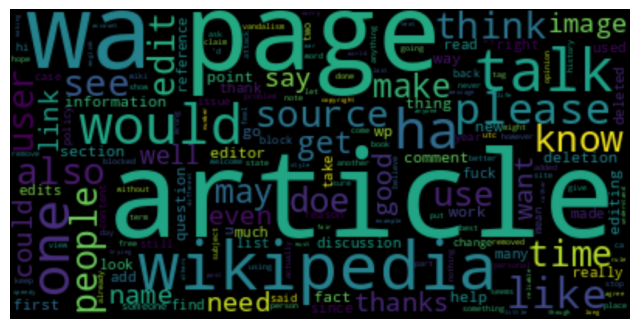

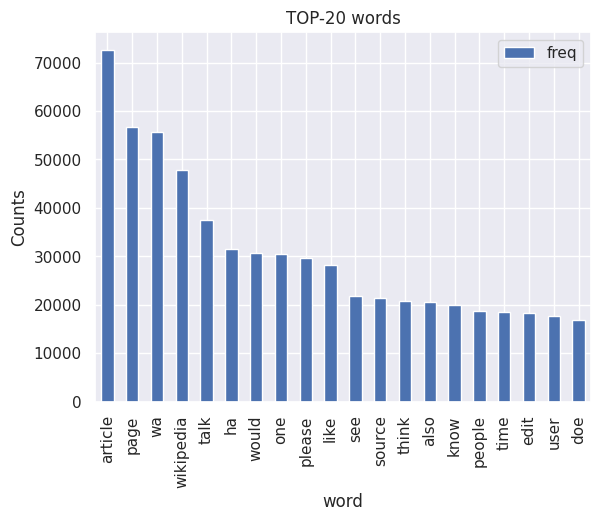

In [22]:
# построим графики с самыми популярными словами
plot_words(word_counter)

# Обучение моделей

In [23]:
# разделим данные на обучающие и тестовые, учитывая, что классы несбалансированы
train_df, test_df = train_test_split(comments_df, test_size=0.2, stratify=comments_df.toxic, random_state=101)

In [24]:
# разделим данные на фичи и таргет
X_train = train_df.drop('toxic', axis=1)
y_train = train_df.toxic

X_test = test_df.drop('toxic', axis=1)
y_test = test_df.toxic

In [25]:
for name, s in [('обучающей', y_train), ('тестовой', y_test)]:
    per = (s.value_counts() / s.shape[0] * 100)[1]
    print(f'Процент токсичных комментариев в {name} выборке: {per:.1f}')

Процент токсичных комментариев в обучающей выборке: 10.2
Процент токсичных комментариев в тестовой выборке: 10.2


In [26]:
train_word_counter = count_words_num(X_train.lemmatized_text)

# посчитаем число слов, которые встречались не менее 10 раз, для обучающей выборки
# затем полученное число используем для того, чтобы задать параметр max_features
train_freq_words_num = len([word for word, count in train_word_counter.items() if count >= 10])
print('Число слов, которые встрчались в комментариях не менее 10 раз:', train_freq_words_num)

100%|██████████| 127433/127433 [00:00<00:00, 150401.02it/s]


Число слов, которые встрчались в комментариях не менее 10 раз: 21019


In [27]:
class GridSearchCVCustom(GridSearchCV):
    all_fit_results = pd.DataFrame(columns=['vectorizer', 'classifier', 'F1'])

    def __init__(self, estimator, param_grid, cv=4):
        super().__init__(estimator, param_grid)

        self.scoring = 'f1'
        self.n_jobs = -1
        self.cv = cv            # по умолчанию, если задано целое число, то будет использван StratifiedKFold
        self.refit = True
        self.verbose = 10
        self.f1_max = None      # здесь будем хранить значение метрики f1 при оптимальном пороге
        self.threshold = 0.5    # значение порога

    @classmethod
    def __add_result(cls, vectorizer_name, model_name, f1_score):
        i = cls.all_fit_results.shape[0] + 1
        cls.all_fit_results.loc[i] = [vectorizer_name, model_name, f1_score]

    def fit_and_plot_results(self, X, y, print_info=True):
        self.fit(X, y)

        y_pred = self.predict(X)

        if isinstance(self.best_estimator_, Pipeline):
            estimator_name = self.best_estimator_[-1].__class__.__name__
            vectorizer_name = self.best_estimator_[0].__class__.__name__
        else:
            estimator_name = self.best_estimator_.__class__.__name__
            vectorizer_name = np.nan

        self.__add_result(vectorizer_name, estimator_name, self.best_score_)

        if print_info:
            # Выведем получившиеся оптимальные параметры
            if self.param_grid:
                print('\nOptimal parameters')
                for param, val in self.best_estimator_.get_params().items():
                    if param in self.param_grid:
                        print(f'    {param}: {val}')

            print(f'\nF1 cross-val score: {self.best_score_:.2f}')

## Bag-of-words

Bag-of-words строится по следующему принципу:
1. определяется словарь слов, используемых в комментариях
2. каждому слову задается `one-hot` вектор, размер которого соответствует размеру словаря
3. для каждого комментария рассчитывается сумма векторов каждого слова, входящего в комментарий

Для построения Bag-of-words будем использовать `CountVectorizer` из библиотеки `scikit-learn`.

В качестве классификаторов будем рассматривать только линейные модели, поскольку на разреженных больших данных деревянные структуры сильно переобучаются, а само обучение происходит крайне долго.

In [28]:
%%time
# для начала обучим несколько линейных моделей, выберем наилучшую, и для нее проведем поиск оптимальных параметров
models = [
    LogisticRegression(max_iter=500, random_state=101),
    BernoulliNB(),
    SGDClassifier(max_iter=500, random_state=101),
    RidgeClassifier(max_iter=500, random_state=101)
]

# чтобы избежать утечки, добавим векторизатор и классификатор в один пайплайн
bow_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english', max_features=train_freq_words_num)),
    ('classifier', None)
])

# определяем лучшую модель
for model in models:
    print(model.__class__.__name__)
    print('=' * 60)
    bow_pipeline.set_params(classifier=model)
    model = GridSearchCVCustom(bow_pipeline, {})
    model.fit_and_plot_results(X_train.lemmatized_text, y_train)
    print('=' * 60, end='\n\n')

LogisticRegression
Fitting 4 folds for each of 1 candidates, totalling 4 fits

F1 cross-val score: 0.75

BernoulliNB
Fitting 4 folds for each of 1 candidates, totalling 4 fits

F1 cross-val score: 0.41

SGDClassifier
Fitting 4 folds for each of 1 candidates, totalling 4 fits

F1 cross-val score: 0.74

RidgeClassifier
Fitting 4 folds for each of 1 candidates, totalling 4 fits

F1 cross-val score: 0.41

CPU times: user 1min 27s, sys: 35.5 s, total: 2min 2s
Wall time: 4min 4s


Лучшей моделью оказалась логистическая регрессия. Найдем для нее оптимальные параметры.

In [29]:
%%time
bow_pipeline.set_params(classifier=LogisticRegression(random_state=101, max_iter=500))
bow_model = GridSearchCVCustom(bow_pipeline,
                                {
                                 'classifier__C': [0.01, 0.1, 1, 10],
                                 'classifier__class_weight': ['balanced', None],
                                 })
bow_model.fit_and_plot_results(X_train.lemmatized_text, y_train)

Fitting 4 folds for each of 8 candidates, totalling 32 fits

Optimal parameters
    classifier__C: 1
    classifier__class_weight: None

F1 cross-val score: 0.75
CPU times: user 37.8 s, sys: 24.6 s, total: 1min 2s
Wall time: 6min 28s


## TF-IDF

Чтобы построить TF-IDF вектора для каждого слова вычисляется два показателя:
1. TF - отношение числа сколько всего раз слово встречается в докусенте, к общему числу слов в данном документе
2. IDF - логарифм отношения общего числа документов к числу документов, в которых встречается рассматриваемое слово

Для построения TF-IDF будем использовать `TfidfVectorizer` из библиотеки `scikit-learn`.

In [30]:
%%time
tfidf_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english', max_features=train_freq_words_num)),
    ('classifier', LogisticRegression(max_iter=500, random_state=101))
])

tfidf_logreg = GridSearchCVCustom(tfidf_pipeline,
                                 {
                                 'classifier__C': [0.01, 0.1, 1, 10, 15],
                                 'classifier__class_weight': ['balanced', None],
                                 })
tfidf_logreg.fit_and_plot_results(X_train.lemmatized_text, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits

Optimal parameters
    classifier__C: 10
    classifier__class_weight: None

F1 cross-val score: 0.77
CPU times: user 30.5 s, sys: 15.3 s, total: 45.8 s
Wall time: 6min 4s


In [31]:
# посмотрим, какие слова дают большевсего вклад в "токсичность" и "нетоксичнотсь" комментария
coefs = tfidf_logreg.best_estimator_['classifier'].coef_  # коэффициенты при векторах
index = coefs.argsort()                                   # сортируем и определяем индексы

feature_names = np.array(tfidf_logreg.best_estimator_['vectorizer'].get_feature_names_out())     # получаем названия фичей (слова)

feature_names_comb = list(feature_names[index][0][:30]) + list(feature_names[index][0][-31::1])  # берем 30 "плохих" и 30 "хороших" слов
index_comb = list(coefs[0][index[0][:30]]) + list(coefs[0][index[0][-31::1]])

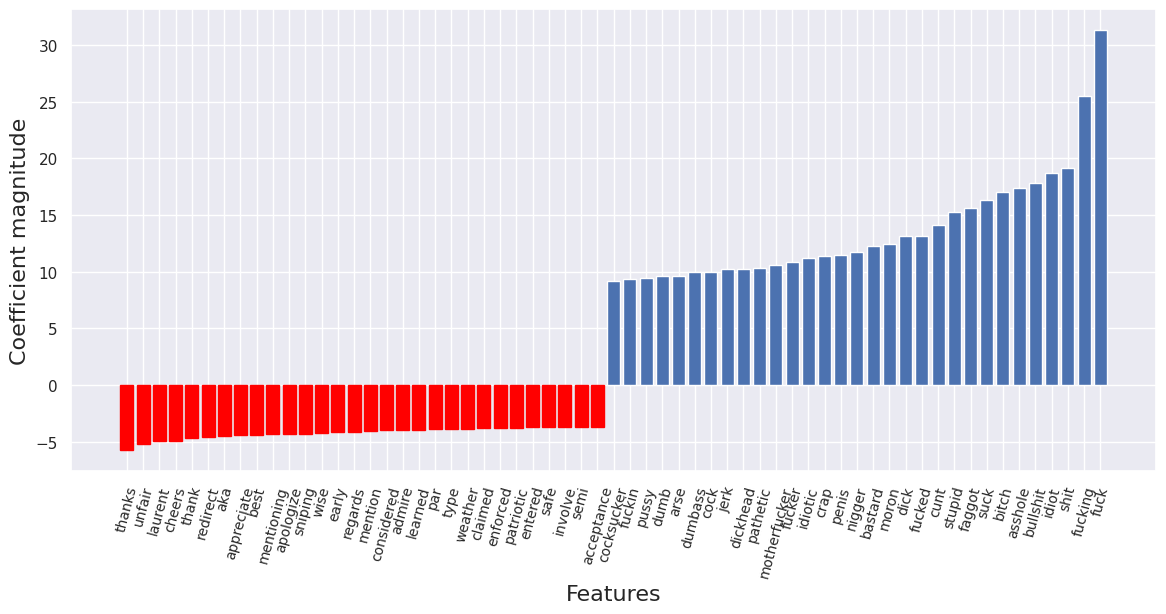

In [32]:
# строим график
plt.figure(figsize=(14,6))
barlist = plt.bar(list(i for i in range(61)), index_comb)
plt.xticks(list(i for i in range(61)),feature_names_comb,rotation=75,size=10)
plt.ylabel('Coefficient magnitude',size=16)
plt.xlabel('Features',size=16)

for i in range(30):
    barlist[i].set_color('red')

plt.show()

##N-граммы

последовательность из $N$ подряд идущих токенов (например, слов). Выделяют: *униграмма* ($N=1$), *биграмма* ($N=2$), *триграмма* ($N=3$)

Строить N-граммы будем с использованием того векторизатора (Count, TF-IDF), который показал наилучший результат в предыдущих пунктах.

In [33]:
%%time
ngrams_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english',
                                   ngram_range=(1, 3))),
    ('classifier', LogisticRegression(max_iter=500, random_state=101))
])

ngrams_logreg = GridSearchCVCustom(ngrams_pipeline,
                                 {
                                 'classifier__C': [0.1, 1, 10],
                                 'vectorizer__max_features': [40000, 60000],
                                 })
ngrams_logreg.fit_and_plot_results(X_train.lemmatized_text, y_train)

Fitting 4 folds for each of 6 candidates, totalling 24 fits

Optimal parameters
    vectorizer__max_features: 60000
    classifier__C: 10

F1 cross-val score: 0.77
CPU times: user 1min 12s, sys: 17.4 s, total: 1min 30s
Wall time: 13min 45s


Результат для совместного рассмотрения 1,2,3-грамм аналогичен, как для униграммы.

## BERT

BERT (Bidirectional Encoder Representations from Transformers) - семейство языковых моделей, разработанных Google. Для английского языка можно выбрать одну из трех моделей: `bert-large-uncased` — самая большая модель, которая, скорее всего, даст наилучшие результаты. Модели поменьше — `bert-base-uncased` и `bert-base-cased`, с которыми более практично работать.

In [34]:
class BERTVectorizer(BaseEstimator, TransformerMixin):

    def __init__(self, bert_model_name='bert-base-uncased', device='cpu'):
        self.bert_model_name = bert_model_name
        self.tokenizer = BertTokenizer.from_pretrained(self.bert_model_name)
        self.model = BertModel.from_pretrained(self.bert_model_name)

        if device == 'cuda':
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            print('Device:', self.device)
        else:
            self.device = 'cpu'

        self.model.to(self.device)

    def fit(self, X):
        return self

    def transform(self, X):
        X = X.copy()

        embeddings = []

        batch_size = 100
        for i in tqdm(range(X.shape[0] // batch_size + 1)):
            X_batch = X.iloc[batch_size*i:batch_size*(i+1)]
            X_batch = X_batch.apply(lambda x: x if len(x) < 512 else x[:512])

            encoded_input = self.tokenizer(X_batch.values.tolist(), return_tensors='pt', padding=True)
            encoded_input.to(self.device)

            with torch.no_grad():
                batch_embeddings = self.model(**encoded_input)[0][:,0,:].to('cpu').numpy()

            embeddings.append(batch_embeddings)

        return np.concatenate(embeddings)

    def fit_transform(self, X):
        return self.transform(X)

In [35]:
bv = BERTVectorizer(device='cuda')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Device: cuda


In [36]:
# bert_pipeline = Pipeline([
#     ('vectorizer', BERTVectorizer(device='cuda', bert_model_name='bert-base-uncased')),
#     ('classifier', LogisticRegression(max_iter=500, random_state=101))
# ])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Device: cuda


In [37]:
# при создании пайплайна возникает конфликт из-за того, что расчеты с использованием модели происходят на GPU
# а обучение модели на CPU, поэтому будем проводить преобразования отдельно
X_train_bert = bv.transform(X_train.lemmatized_text)

100%|██████████| 1275/1275 [16:59<00:00,  1.25it/s]


In [39]:
bert_logreg = GridSearchCVCustom(LogisticRegression(max_iter=500, random_state=101), {'C': [10, 20]})
bert_logreg.fit_and_plot_results(X_train_bert, y_train)

Fitting 4 folds for each of 2 candidates, totalling 8 fits

Optimal parameters
    C: 20

F1 cross-val score: 0.72


Использование BERT не позволило улучшить результат, он только ухудшился. Возможно это связано с тем, что первичную обработку комментариев стоило проводить как-то иначе. Либо стоило дообучить модель на имеющихся данных.

## Detoxify

Попробуем использувать предобученную модель Detoxify, которая заточена на распознавание токсичности комментариев.

In [41]:
# скачиваем и закидываем на GPU
detoxify = Detoxify('original', device='cuda')

In [42]:
%%time
toxicity = np.array([])

batch_size = 128
for i in tqdm(range(X_train.shape[0] // batch_size + 1)):
    X_batch = X_train['lemmatized_text'].iloc[batch_size*i:batch_size*(i+1)].values.tolist()
    toxicity = np.append(toxicity, np.array(detoxify.predict(X_batch)['toxicity']))

100%|██████████| 996/996 [1:14:15<00:00,  4.47s/it]

CPU times: user 1h 13min 51s, sys: 7.44 s, total: 1h 13min 59s
Wall time: 1h 14min 15s


In [45]:
thresholds = np.linspace(0, 1, 101)

f1_values = np.array([f1_score(y_train.values, toxicity > t) for t in thresholds])

max_f1 = f1_values.max()
best_threshold = thresholds[f1_values.argmax()]

print(f'Best F1: {max_f1:.2f}')
print(f'Best threshold: {best_threshold:.2f}')

Best F1: 0.91
Best threshold: 0.42


In [46]:
# добавляем результаты в таблицу
bert_logreg.all_fit_results.loc[9] = ['Detoxify', 'Detoxify', max_f1]

## Промежуточной вывод

In [47]:
# выведем лучшую модель
bert_logreg.all_fit_results.loc[8, 'vectorizer'] = 'BERT'
bert_logreg.all_fit_results.sort_values('F1')

,vectorizer,classifier,F1
4,CountVectorizer,RidgeClassifier,0.407368
2,CountVectorizer,BernoulliNB,0.414205
8,BERT,LogisticRegression,0.718421
3,CountVectorizer,SGDClassifier,0.738352
1,CountVectorizer,LogisticRegression,0.750798
5,CountVectorizer,LogisticRegression,0.750798
7,TfidfVectorizer,LogisticRegression,0.765904
6,TfidfVectorizer,LogisticRegression,0.767802
9,Detoxify,Detoxify,0.907553


# Тестирование лучшей модели

Лучшей моделью оказалась Detoxify. Протестируем ее.

In [49]:
%%time
toxicity_test = np.array([])

batch_size = 128
for i in tqdm(range(X_test.shape[0] // batch_size + 1)):
    X_batch = X_test['lemmatized_text'].iloc[batch_size*i:batch_size*(i+1)].values.tolist()
    toxicity_test = np.append(toxicity_test, np.array(detoxify.predict(X_batch)['toxicity']))

100%|██████████| 249/249 [18:37<00:00,  4.49s/it]

CPU times: user 18min 21s, sys: 2.24 s, total: 18min 23s
Wall time: 18min 37s


In [52]:
# по метрике F1 нет смысла сравнивать с DummyClassifier при таком сильном дисбалансе классов
print(f'F1 на тестовых данных для лучшей модели: {f1_score(y_test.values, toxicity_test > best_threshold):.3f}')

F1 на тестовых данных для лучшей модели: 0.909


# Вывод

В процессе выполнения работы мы выполнили:
- предобработку текста (очистка и лемматизация)
- анализ классов
- векторизацию с использованием Bag-of-Words, TF-IDF и эмбеддингов на основе моделей BERT и Detoxify
- обучение различными линейными классификаторами

Наилучшей оказалась модель Detoxify. Результат тестирования показал, что модель удовлетворяет заявленным требованиям (F1 > 0.75).